<a href="https://colab.research.google.com/github/SamuelSS09/face-mask-detection-projet-s9/blob/main/Test_MobilNetV2_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source 1 : https://github.com/HOD101s/Face-Mask-Detection

Source 2 : https://github.com/mk-gurucharan/Face-Mask-Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil

from shutil import copyfile

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D, GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


Fetching Our Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/My Drive/PROJET S9/Classification/Codes/Datasets/3class_dataset.zip" -d "/content/datasets/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/n_dataset/no_mask/2138.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._2138.png  
  inflating: /content/n_dataset/no_mask/3226.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._3226.png  
  inflating: /content/n_dataset/no_mask/1431.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._1431.png  
  inflating: /content/n_dataset/no_mask/1357.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._1357.png  
  inflating: /content/n_dataset/no_mask/0049.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._0049.png  
  inflating: /content/n_dataset/no_mask/2886.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._2886.png  
  inflating: /content/n_dataset/no_mask/2892.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._2892.png  
  inflating: /content/n_dataset/no_mask/1343.png  
  inflating: /content/__MACOSX/n_dataset/no_mask/._1343.png  
  inflating: /content/n_dataset/no_mask/1425.

In [33]:
# base = ''

BATCH_SIZE = 32
EPOCHS = 75

base = ''

DATAPATH = os.path.join('datasets/3_classes_final_Dataset/')
MASK_PATH = os.path.join(DATAPATH,'well_ported_mask/')
NO_MASK_PATH = os.path.join(DATAPATH,'no_mask/')
WRONG_MASK_PATH = os.path.join(DATAPATH,'wrong_ported_mask/')

TRAIN_PATH = os.path.join(DATAPATH,'traindata/')
TRAIN_MASK_PATH = os.path.join(DATAPATH,'traindata/well_ported_mask/')
TRAIN_NO_MASK_PATH = os.path.join(DATAPATH,'traindata/no_mask/')
TRAIN_WRONG_MASK_PATH = os.path.join(DATAPATH,'traindata/wrong_ported_mask/')

VAL_PATH = os.path.join(DATAPATH,'valdata/')
VAL_MASK_PATH = os.path.join(DATAPATH,'valdata/well_ported_mask/')
VAL_NO_MASK_PATH = os.path.join(DATAPATH,'valdata/no_mask/')
VAL_WRONG_MASK_PATH = os.path.join(DATAPATH,'valdata/wrong_ported_mask/')

# TESTPATH = os.path.join(base,'our_dataset/testdata/')
# TEST_MASK_PATH = os.path.join(base,'our_dataset/testdata/mask/')
# TEST_NOMASK_PATH = os.path.join(base,'our_dataset/testdata/no_mask/')

WEIGHTS_PATH = os.path.join(base,'weights/')
os.makedirs(WEIGHTS_PATH,exist_ok = True)
WEIGHTS_FILE = os.path.join(WEIGHTS_PATH,f'3class_MobileNetV2_TransferTun_{EPOCHS}_epochs_{BATCH_SIZE}.h5')
CHECKPOINTS_PATH = os.path.join(base, 'checkpoints/')

Visualizing our data

In [37]:
def view(pth):
    images = list()
    for img in random.sample(os.listdir(pth),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(pth,images[i])))
            i+=1

In [38]:
NumberMaskData = os.listdir(MASK_PATH)
print(len(NumberMaskData))

4470


In [39]:
NumberNOMaskData = os.listdir(NO_MASK_PATH)
print(len(NumberNOMaskData))

1253


In [46]:
NumberWrongMaskData = os.listdir(WRONG_MASK_PATH)
print(len(NumberWrongMaskData))

202


In [41]:
# view(MASKPATH)

In [42]:
# view(NOMASKPATH)

Analysing our Data

In [55]:
fig = go.Figure(
    data=[go.Pie(labels=['WITHMASK','WITHOUTMASK','WRONGMASK'], 
        values=[NumberMaskData , NumberNOMaskData , NumberWrongMaskData ])
    ])
fig.show()

In [52]:
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(TRAIN_MASK_PATH, exist_ok=True)
os.makedirs(TRAIN_NO_MASK_PATH, exist_ok=True)
os.makedirs(TRAIN_WRONG_MASK_PATH, exist_ok=True)

os.makedirs(VAL_PATH, exist_ok=True)
os.makedirs(VAL_MASK_PATH, exist_ok=True)
os.makedirs(VAL_NO_MASK_PATH, exist_ok=True)
os.makedirs(VAL_WRONG_MASK_PATH, exist_ok=True)

# os.makedirs(TESTPATH, exist_ok=True)
# os.makedirs(os.path.join(TESTPATH,'mask'), exist_ok=True)
# os.makedirs(os.path.join(TESTPATH,'no_mask'), exist_ok=True)

In [56]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE + unitData
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = SOURCE + unitData
        final_train_set = TRAINING + unitData
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = SOURCE + unitData
        final_test_set = TESTING + unitData
        copyfile(temp_test_set, final_test_set)


To clean the NO_MASK and MASK folders

In [57]:

from pathlib import Path


[f.unlink() for f in Path(TRAIN_MASK_PATH).glob("*") if f.is_file()] 
[f.unlink() for f in Path(TRAIN_NO_MASK_PATH).glob("*") if f.is_file()] 

# [f.unlink() for f in Path(TEST_MASK_PATH).glob("*") if f.is_file()] 
# [f.unlink() for f in Path(TEST_NOMASK_PATH).glob("*") if f.is_file()] 

[f.unlink() for f in Path(VAL_MASK_PATH).glob("*") if f.is_file()] 
[f.unlink() for f in Path(VAL_NO_MASK_PATH).glob("*") if f.is_file()] 

print("The training set mask/no_mask/wrong_mask sizes: (",len(os.listdir(TRAIN_MASK_PATH)),",",len(os.listdir(TRAIN_NO_MASK_PATH)),",",len(os.listdir(TRAIN_WRONG_MASK_PATH)),")")
print("The test set mask/no_mask/wrong_mask sizes: (",len(os.listdir(VAL_MASK_PATH)),",",len(os.listdir(VAL_NO_MASK_PATH)),",",len(os.listdir(VAL_WRONG_MASK_PATH)),")")
# print("The test set mask/no_mask sizes: (",len(os.listdir(TEST_MASK_PATH)),",",len(os.listdir(TEST_NOMASK_PATH)),")")

The training set mask/no_mask/wrong_mask sizes: ( 0 , 0 , 0 )
The test set mask/no_mask/wrong_mask sizes: ( 0 , 0 , 0 )


In [58]:
split_size = .80
split_data(MASK_PATH, TRAIN_MASK_PATH, VAL_MASK_PATH, split_size)
split_data(NO_MASK_PATH, TRAIN_NO_MASK_PATH, VAL_NO_MASK_PATH, split_size)
split_data(WRONG_MASK_PATH, TRAIN_WRONG_MASK_PATH, VAL_WRONG_MASK_PATH, split_size)

In [59]:
print("The number of images with facemask in the training set:", len(os.listdir(TRAIN_MASK_PATH)))
print("The number of images without facemask in the training set:", len(os.listdir(TRAIN_NO_MASK_PATH)))
print("The number of images with improperly worn mask in the validation set:", len(os.listdir(TRAIN_WRONG_MASK_PATH)))
print("The number of images with facemask in the test set:", len(os.listdir(VAL_MASK_PATH)))
print("The number of images without facemask in the validation set:", len(os.listdir(VAL_NO_MASK_PATH)))
print("The number of images with improperly worn mask in the validation set:", len(os.listdir(VAL_WRONG_MASK_PATH)))

The number of images with facemask in the training set: 3576
The number of images without facemask in the training set: 1002
The number of images with improperly worn mask in the validation set: 161
The number of images with facemask in the test set: 894
The number of images without facemask in the validation set: 251
The number of images with improperly worn mask in the validation set: 41


Preparing Data Input Pipelines

In [60]:
trainGen = ImageDataGenerator(rescale=1.0/255.0,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

testGen = ImageDataGenerator(
    rescale= 1.0/255.0,
)

Ref : https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [61]:
train = trainGen.flow_from_directory(
    TRAIN_PATH, 
    target_size=(128, 128),
    classes=['no_mask','well_ported_mask', 'wrong_ported_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

validation = testGen.flow_from_directory(
    VAL_PATH, 
    target_size=(128, 128),
    classes=['no_mask','well_ported_mask', 'wrong_ported_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=False,
)


Found 4739 images belonging to 3 classes.
Found 1186 images belonging to 3 classes.


In [62]:
# merci: https://yann-leguilly.gitlab.io/post/2019-10-09-tensorflow-tfdata/

train_ds = tf.data.Dataset.from_generator(lambda: train,
                     output_types=(tf.float32, tf.float32),
                     output_shapes=([BATCH_SIZE, 128, 128, 3],
                                    [BATCH_SIZE, 2])
                     )

valid_ds = tf.data.Dataset.from_generator(lambda: validation,
                     output_types=(tf.float32, tf.float32),
                     output_shapes=([1, 128, 128, 3],
                                    [1, 2])
                     )

Model Building

In [63]:
imgs = list()
classes = list()
for i,c in train_ds.take(9):
    imgs.append(np.array(i[0]))
    classes.append(np.array(c[0]))

    
fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
i=0
for row in range(3):
    for col in range(3):
        ax[row,col].imshow(imgs[i])
        ax[row,col].title.set_text('Mask' if classes[i][0] == 1.0 else 'No mask')
        i+=1
# plt.close()

InvalidArgumentError: ValueError: `generator` yielded an element of shape (32, 3) where an element of shape (32, 2) was expected.
Traceback (most recent call last):

  File "/Users/samuelsoaressantos/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 244, in __call__
    ret = func(*args)

  File "/Users/samuelsoaressantos/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "/Users/samuelsoaressantos/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 861, in generator_py_func
    raise ValueError(

ValueError: `generator` yielded an element of shape (32, 3) where an element of shape (32, 2) was expected.


	 [[{{node PyFunc}}]]

In [64]:
mob = MobileNetV2(
    input_shape = (128,128,3),
    include_top = False,
    weights = 'imagenet',
)
mob.trainable = False


TRANSFER TRAINING

In [65]:
model = Sequential()
model.add(mob)
model.add(GlobalMaxPool2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,340,163
Trainable params: 82,179
Non-trainable params: 2,257,984
_________________________________________________________________


In [69]:


model.compile(optimizer=Adam(learning_rate=1e-3),loss='categorical_crossentropy',metrics=['accuracy'])
model.load_weights('weights/3class_MobileNetV2_V2_20_epochs_64.h5')



In [70]:
# checkpoint_filepath3 = "/content/drive/My Drive/PROJET S9/Classification/Codes/check_points3"

checkpoint = ModelCheckpoint(
    CHECKPOINTS_PATH,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)


Ref : https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd

In [71]:
early_stopping = EarlyStopping(monitor='val_loss', 
                                patience=3, 
                                min_delta=0.001, 
                                mode='max')
# while monitoring val_accuraccy model achieve 1.00 result at 17 epochs

Ref : https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/

In [72]:
STEP_SIZE_TRAIN=train.n//train.batch_size
STEP_SIZE_VALID=validation.n//validation.batch_size

print("Steps in training set:", STEP_SIZE_TRAIN)
print("Steps in validation set:", STEP_SIZE_VALID)

Steps in training set: 148
Steps in validation set: 37


In [ ]:
history = model.fit_generator(generator=train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    callbacks = [checkpoint]
)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/75
148/148 [==============================] - ETA: 0s - loss: 1.4117 - accuracy: 0.5874
Epoch 00001: val_loss improved from inf to 0.52145, saving model to checkpoints/
148/148 [==============================] - 40s 268ms/step - loss: 1.4117 - accuracy: 0.5874 - val_loss: 0.5215 - val_accuracy: 0.7812
Epoch 2/75
148/148 [==============================] - ETA: 0s - loss: 0.5842 - accuracy: 0.7803
Epoch 00002: val_loss improved from 0.52145 to 0.35076, saving model to checkpoints/
148/148 [==============================] - 42s 283ms/step - loss: 0.5842 - accuracy: 0.7803 - val_loss: 0.3508 - val_accuracy: 0.8936
Epoch 3/75
148/148 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.8184
Epoch 00003: val_loss improved from 0.35076 to 0.31666, saving model to checkpoints/
148/148 [==============================] - 39s 260ms/step - loss: 0.5050 - accuracy: 0.8184 - val_loss: 0.3167 - val_

148/148 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.9006
Epoch 00027: val_loss did not improve from 0.23390
148/148 [==============================] - 41s 274ms/step - loss: 0.2960 - accuracy: 0.9006 - val_loss: 0.2356 - val_accuracy: 0.9265
Epoch 28/75
148/148 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.9018
Epoch 00028: val_loss improved from 0.23390 to 0.22990, saving model to checkpoints/
148/148 [==============================] - 38s 259ms/step - loss: 0.2969 - accuracy: 0.9018 - val_loss: 0.2299 - val_accuracy: 0.9282
Epoch 29/75
148/148 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.9029
Epoch 00029: val_loss did not improve from 0.22990
148/148 [==============================] - 38s 259ms/step - loss: 0.2890 - accuracy: 0.9029 - val_loss: 0.2490 - val_accuracy: 0.9172
Epoch 30/75
148/148 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.9012
Epoch 00030: val_loss did not impro

Epoch 55/75
148/148 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.9055
Epoch 00055: val_loss did not improve from 0.21558
148/148 [==============================] - 39s 262ms/step - loss: 0.2680 - accuracy: 0.9055 - val_loss: 0.2286 - val_accuracy: 0.9274
Epoch 56/75
148/148 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.9116
Epoch 00056: val_loss did not improve from 0.21558
148/148 [==============================] - 39s 263ms/step - loss: 0.2632 - accuracy: 0.9116 - val_loss: 0.2305 - val_accuracy: 0.9307
Epoch 57/75
 31/148 [=====>........................] - ETA: 24s - loss: 0.2782 - accuracy: 0.9103

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.save_weights(WEIGHTS_FILE)
#model.load_weights(checkpoint_filepath2)

In [ ]:
model.evaluate_generator(generator=validation, steps=STEP_SIZE_VALID)

[0.05327414348721504, 0.9854166507720947]

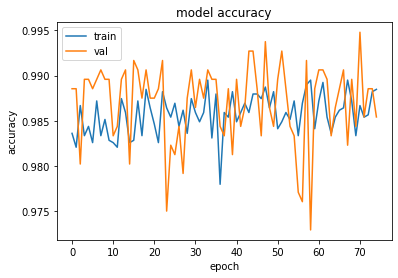

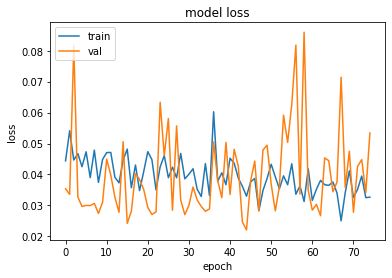

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Points to check : https://cs231n.github.io/neural-networks-3/#sanitycheck

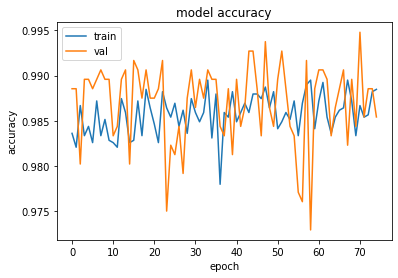

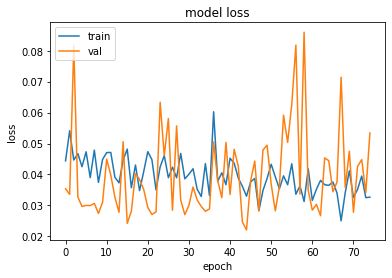

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NOTES:

- Tester les codes sur 10 images (e.g) pour voir si le code marche bien
- Voir la sortie de MobileNetV2
- Le CNN doit voir si la partie basse de l'image est dense
- Peut etre ajouter un 3eme set de validation (pour le moment on a train et test)
- Entrainer sur moins d'images au depart
- Comment mesurer la vitesse d'execution du code??
